In [1]:
import numpy as np

from CNN import ThreeLayerConvNet
from model import myModel

from keras.models import Model

import h5py
import time
import pickle
import timeit, os, math

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
import tensorflow as tf
import numpy as np
import time
from datetime import timedelta
import os
import keras
from keras.datasets import cifar100
from keras.utils import to_categorical

In [3]:
def SoftMax(s):
    # minus max to avoid large s case
    p = np.exp(s-np.expand_dims(np.max(s,axis=1),axis=1))/\
    np.expand_dims(np.exp(s-np.expand_dims(np.max(s,axis=1),axis=1)).sum(axis=1),axis=1)  # matrix of size NxK
    return p

In [4]:
teacher_train_logits = np.load(
    'best_ensemble_logits_100.npz')['arr_0']

In [5]:
tf.logging.set_verbosity(tf.logging.ERROR)

In [6]:
(images_train, cls_train), (images_test, cls_test) =  cifar100.load_data()
images_train = images_train.astype('float32')
images_test = images_test.astype('float32')
images_train /= 255
images_test /= 255
n_classes = 100
labels_train = to_categorical(cls_train, n_classes)
labels_test = to_categorical(cls_test, n_classes)

In [7]:
# Prepare data to train with small model
data = {'X_train': images_train.transpose(0,3,1,2).copy(), 'y_train': np.argmax(labels_train,axis=1),
        'X_val': images_test.transpose(0,3,1,2).copy(), 'y_val': np.argmax(labels_test,axis=1),
       }

In [26]:
def temp_loop(temp,epochs, teacher_train_logits):
    for t in temp:
        num_networks=15
        temp=t
        models_s_15 = teacher_train_logits/temp
        softmax_ensemb_models_15 = np.zeros_like(models_s_15)
        for i in range(num_networks):
               softmax_ensemb_models_15[i] = SoftMax(models_s_15[i])
        average_softmax_15 = np.mean(softmax_ensemb_models_15, axis=0)

        net_15 = ThreeLayerConvNet(input_dim=(3, 32, 32),num_classes=100,num_filters=16,filter_size=5,hidden_dim=512,
                            reg=0.001,weight_scale=1,dtype=np.float32)
        small_model_15 = myModel(net_15, data,
                              num_epochs=epochs, batch_size=100,
                              optimizer='adam',
                              optim_config={
                                  'learning_rate': 1e-3,},
                              temperature=temp, soft_target=average_softmax_15, distill_mode='proba',
                              verbose=True, print_every=100)
        tic = time.time()
        small_model_15.train()
        toc = time.time()
        print('Execution time: ',toc-tic)
        val_acc = small_model_15.check_accuracy(data['X_val'],data['y_val'])
        print('Test accuracy: {}'.format(val_acc))
        results[temp] =  val_acc
        return results

In [ ]:
results_without_noise=[0.013100,0.236000,0.273400,0.296300,0.300700,0.314700,0.312100,0.330600,0.330100,0.341100,0.339600,0.339600,
0.346500,0.348700,0.344600,0.351000,0.348000,0.355600,0.354300,0.356600,0.355000,0.352300,0.361900,0.359200,
0.356700,0.365600,0.363200,0.370800,0.362500,0.368700,0.366300,0.363900,0.366000,0.373600,0.364500,0.370700,
0.376400,0.377100,0.378900,0.372400,0.374600,0.374600,0.378700,0.376800,0.377900,0.375600,0.378500,0.382900,
0.382200,0.383000, 0.372900]

# Train for different values of temperature

# Train for longer T = 2

In [29]:
#save results
# np.savez('temp-tests-nonnoise-ensembling-50epochs', res2)

In [16]:
#save results first temperature tests.
# np.savez('temp-tests-nonnoise-ensembling-t1-t20', results)

In [10]:
#Getting results non-noise ensemble.
resultst1t20 = np.load('temp-tests-nonnoise-ensembling-t1-t20.npz')['arr_0']
temperaturest1t20= list(resultst1t20.item().keys())
accuraciest1t20 = list(resultst1t20.item().values())
temperaturest25t50 = [t for t in range(25,55,5)]
accuracies25t50 = np.load('accuracies25-50.npz')['arr_0']
temp_tested_no_noise_ensembling = temperaturest1t20 + temperaturest25t50
acc_no_noise_ensembling = accuraciest1t20 + accuracies25t50

In [11]:
accuracies_noisy_esemblingt1t20= np.load('accuracies_noisy_esemblingt1t20.npz')['arr_0']
accuracies_noisy_esemblingt1t20 = list(accuracies_noisy_esemblingt1t20)

In [12]:
#Getting results noisy ensembling.
accuracies_noisy_esemblingt1t20= np.load('accuracies_noisy_esemblingt1t20.npz')['arr_0']
accuracies_noisy_esemblingt1t20 = list(accuracies_noisy_esemblingt1t20)
temperatures_noisy_esemblingt1t20 = [i+1 for i in range(20)]
results_noise_introduction = np.load('resultst25t50.npz')['arr_0']
accuracies_noisy_esemblingt25t50 = list(results_noise_introduction.item().values())
temperatures_noisy_esemblingt25t50 = list(results_noise_introduction.item().keys())

temp_tested_no_noise_ensembling
acc_noise_ensembling = accuracies_noisy_esemblingt1t20 + accuracies_noisy_esemblingt25t50
temp_noise_ensembling = temperatures_noisy_esemblingt1t20 + temperatures_noisy_esemblingt25t50

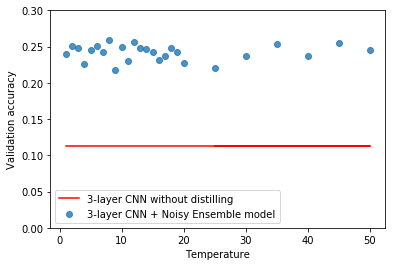

In [13]:
#Student model trained without distilling gave a 11.3% accuracy for 1 epoch  & 1e-3 learning rate 
#with the same parameters we're trainnining the student model.
y = [0.113] * len(list(temp_noise_ensembling))
fig = plt.figure()
plt.scatter(temp_noise_ensembling,acc_noise_ensembling, alpha=0.8, label='3-layer CNN + Noisy Ensemble model')
plt.plot(temp_noise_ensembling, y ,c='red', label='3-layer CNN without distilling')
plt.xlabel("Temperature")
plt.ylabel("Validation accuracy")
plt.legend(loc='best')
plt.ylim(0.0, 0.30)
fig.savefig('distill_cifar100_with-prepro.pdf')
plt.show()

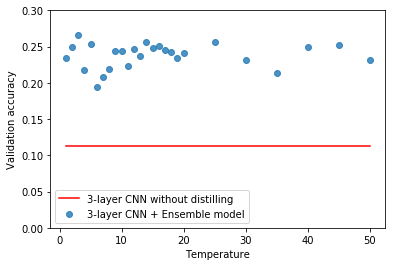

In [14]:
#Student model trained without distilling gave a 11.3% accuracy for 1 epoch  & 1e-3 learning rate 
#with the same parameters we're trainnining the student model.
y = [0.113] * len(list(temp_tested_no_noise_ensembling))
fig = plt.figure()
plt.scatter(temp_tested_no_noise_ensembling, acc_no_noise_ensembling, alpha=0.8, label='3-layer CNN + Ensemble model')
plt.plot(list(temp_tested_no_noise_ensembling), y ,c='red', label='3-layer CNN without distilling')
plt.xlabel("Temperature")
plt.ylabel("Validation accuracy")
plt.legend(loc='best')
plt.ylim(0.0, 0.30)
fig.savefig('distill_cifar100_without-prepro.pdf')
plt.show()

In [ ]:
#Train for 2 epochs to choose a value of T:

In [15]:
# temp = [t+1 for t in range(20)]
# temp = [25,30,35,40,45,50]
temp = [1,2,4,6,8,10,15,20]
results = {}
for t in temp:
    num_networks=15
    temp=t
    models_s_15 = teacher_train_logits/temp
    softmax_ensemb_models_15 = np.zeros_like(models_s_15)
    for i in range(num_networks):
           softmax_ensemb_models_15[i] = SoftMax(models_s_15[i])
    average_softmax_15 = np.mean(softmax_ensemb_models_15, axis=0)
    
    net_15 = ThreeLayerConvNet(input_dim=(3, 32, 32),num_classes=100,num_filters=16,filter_size=5,hidden_dim=512,
                        reg=0.001,weight_scale=1,dtype=np.float32)
    small_model_15 = myModel(net_15, data,
                          num_epochs=2, batch_size=100,
                          optimizer='adam',
                          optim_config={
                              'learning_rate': 1e-3,},
                          temperature=temp, soft_target=average_softmax_15, distill_mode='proba',
                          verbose=True, print_every=100)
    tic = time.time()
    small_model_15.train()
    toc = time.time()
    print('Execution time: ',toc-tic)
    val_acc = small_model_15.check_accuracy(data['X_val'],data['y_val'])
    print('Test accuracy: {}'.format(val_acc))
    results[temp] =  val_acc
    
    

(Iteration 1 / 1000) loss: 5.308493
(Epoch 0 / 2) train acc: 0.017000; val_acc: 0.015500
(Iteration 101 / 1000) loss: 4.008245
(Iteration 201 / 1000) loss: 3.802519
(Iteration 301 / 1000) loss: 3.552295
(Iteration 401 / 1000) loss: 3.604626
(Epoch 1 / 2) train acc: 0.270060; val_acc: 0.249400
(Iteration 501 / 1000) loss: 3.416206
(Iteration 601 / 1000) loss: 3.272064
(Iteration 701 / 1000) loss: 3.271117
(Iteration 801 / 1000) loss: 3.272746
(Iteration 901 / 1000) loss: 3.319585
(Epoch 2 / 2) train acc: 0.316080; val_acc: 0.280000
Execution time:  1420.6632010936737
Test accuracy: 0.28
(Iteration 1 / 1000) loss: 12.201511
(Epoch 0 / 2) train acc: 0.013040; val_acc: 0.013600
(Iteration 101 / 1000) loss: 10.497541
(Iteration 201 / 1000) loss: 10.078917
(Iteration 301 / 1000) loss: 10.033035
(Iteration 401 / 1000) loss: 9.532711
(Epoch 1 / 2) train acc: 0.270760; val_acc: 0.247200
(Iteration 501 / 1000) loss: 9.475455
(Iteration 601 / 1000) loss: 9.658741
(Iteration 701 / 1000) loss: 9.14

In [25]:
#Load noisy ensemble model logits:
teacher_train_logits_noise = np.load(
    'best_ensemble_logits_new_cs.npz')['arr_0']

# Train for longer noisy Ensemble model: T = 2

In [28]:
res2_noisy = temp_loop([2], 50, teacher_train_logits_noise)

(Iteration 1 / 25000) loss: 12.293212
(Epoch 0 / 50) train acc: 0.016820; val_acc: 0.015200
(Iteration 101 / 25000) loss: 10.464180
(Iteration 201 / 25000) loss: 9.828085
(Iteration 301 / 25000) loss: 9.147086
(Iteration 401 / 25000) loss: 9.449183
(Epoch 1 / 50) train acc: 0.283520; val_acc: 0.246200
(Iteration 501 / 25000) loss: 9.584510
(Iteration 601 / 25000) loss: 9.402679
(Iteration 701 / 25000) loss: 9.141906
(Iteration 801 / 25000) loss: 9.303289
(Iteration 901 / 25000) loss: 9.298620
(Epoch 2 / 50) train acc: 0.347400; val_acc: 0.305200
(Iteration 1001 / 25000) loss: 9.169310
(Iteration 1101 / 25000) loss: 9.003526
(Iteration 1201 / 25000) loss: 9.213834
(Iteration 1301 / 25000) loss: 8.722632
(Iteration 1401 / 25000) loss: 9.106576
(Epoch 3 / 50) train acc: 0.372300; val_acc: 0.311500
(Iteration 1501 / 25000) loss: 9.421750
(Iteration 1601 / 25000) loss: 8.675631
(Iteration 1701 / 25000) loss: 8.498113
(Iteration 1801 / 25000) loss: 9.014125
(Iteration 1901 / 25000) loss: 8.6

(Epoch 32 / 50) train acc: 0.552880; val_acc: 0.404400
(Iteration 16001 / 25000) loss: 8.469830
(Iteration 16101 / 25000) loss: 8.232750
(Iteration 16201 / 25000) loss: 8.731598
(Iteration 16301 / 25000) loss: 8.560170
(Iteration 16401 / 25000) loss: 8.494757
(Epoch 33 / 50) train acc: 0.542600; val_acc: 0.393100
(Iteration 16501 / 25000) loss: 8.937469
(Iteration 16601 / 25000) loss: 8.551062
(Iteration 16701 / 25000) loss: 8.726987
(Iteration 16801 / 25000) loss: 8.419985
(Iteration 16901 / 25000) loss: 8.493743
(Epoch 34 / 50) train acc: 0.539540; val_acc: 0.385900
(Iteration 17001 / 25000) loss: 8.839220
(Iteration 17101 / 25000) loss: 8.859821
(Iteration 17201 / 25000) loss: 8.355398
(Iteration 17301 / 25000) loss: 8.572379
(Iteration 17401 / 25000) loss: 8.541799
(Epoch 35 / 50) train acc: 0.547280; val_acc: 0.397000
(Iteration 17501 / 25000) loss: 8.667198
(Iteration 17601 / 25000) loss: 8.786004
(Iteration 17701 / 25000) loss: 8.548442
(Iteration 17801 / 25000) loss: 8.341613
(

# Train for longer  Ensemble model without noise introduction: T = 2

In [22]:
res2 = temp_loop([2], 50,teacher_train_logits)

(Iteration 1 / 25000) loss: 12.455951
(Epoch 0 / 50) train acc: 0.013460; val_acc: 0.013100
(Iteration 101 / 25000) loss: 10.968055
(Iteration 201 / 25000) loss: 10.133617
(Iteration 301 / 25000) loss: 9.893723
(Iteration 401 / 25000) loss: 9.451598
(Epoch 1 / 50) train acc: 0.245700; val_acc: 0.236000
(Iteration 501 / 25000) loss: 9.924546
(Iteration 601 / 25000) loss: 9.849385
(Iteration 701 / 25000) loss: 9.748007
(Iteration 801 / 25000) loss: 9.178021
(Iteration 901 / 25000) loss: 9.513850
(Epoch 2 / 50) train acc: 0.303420; val_acc: 0.273400
(Iteration 1001 / 25000) loss: 9.484136
(Iteration 1101 / 25000) loss: 9.436356
(Iteration 1201 / 25000) loss: 9.386505
(Iteration 1301 / 25000) loss: 9.340844
(Iteration 1401 / 25000) loss: 9.314654
(Epoch 3 / 50) train acc: 0.336280; val_acc: 0.296300
(Iteration 1501 / 25000) loss: 9.310433
(Iteration 1601 / 25000) loss: 9.308010
(Iteration 1701 / 25000) loss: 9.353910
(Iteration 1801 / 25000) loss: 9.422428
(Iteration 1901 / 25000) loss: 9.

(Epoch 32 / 50) train acc: 0.475860; val_acc: 0.366000
(Iteration 16001 / 25000) loss: 8.883064
(Iteration 16101 / 25000) loss: 9.035684
(Iteration 16201 / 25000) loss: 8.658875
(Iteration 16301 / 25000) loss: 9.005415
(Iteration 16401 / 25000) loss: 8.814577
(Epoch 33 / 50) train acc: 0.479000; val_acc: 0.373600
(Iteration 16501 / 25000) loss: 8.830784
(Iteration 16601 / 25000) loss: 9.204075
(Iteration 16701 / 25000) loss: 8.670854
(Iteration 16801 / 25000) loss: 9.016139
(Iteration 16901 / 25000) loss: 8.717662
(Epoch 34 / 50) train acc: 0.478320; val_acc: 0.364500
(Iteration 17001 / 25000) loss: 8.868598
(Iteration 17101 / 25000) loss: 9.165488
(Iteration 17201 / 25000) loss: 9.055957
(Iteration 17301 / 25000) loss: 8.710528
(Iteration 17401 / 25000) loss: 8.701363
(Epoch 35 / 50) train acc: 0.482380; val_acc: 0.370700
(Iteration 17501 / 25000) loss: 8.816292
(Iteration 17601 / 25000) loss: 9.106414
(Iteration 17701 / 25000) loss: 9.048093
(Iteration 17801 / 25000) loss: 8.977487
(